In [210]:
from astropy.io import fits
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm
import warnings
import os
import sys

In [211]:
c = const.c.cgs.value * 1e-5  # speed of light in km/s
NaDI = 5897
NaDII = 5891

## Data
- DESI BGS
- 100638 spectra (HSC spring footprint)
- FLUX : integrated 1D coadd flux
- INVERSE VARIANCE : integrated 1D inverse variance
- MASK : 
    - 0 : Good
    - 1 : Bad pixel

In [212]:
# Replace to the correct path
data = fits.open('/Users/hyp0515/data/0715_Spring_BGS_ALL_trimmed.fits')
data.info()

Filename: /Users/hyp0515/data/0715_Spring_BGS_ALL_trimmed.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     16   100638R x 4C   [K, D, D, D]   
  2  FLUX          1 ImageHDU         9   (7781, 1, 100638)   float64   
  3  INVERSE VARIANCE    1 ImageHDU         9   (7781, 1, 100638)   float64   
  4  MASK          1 ImageHDU        11   (7781, 1, 100638)   int32 (rescales to uint32)   


In [213]:
wavelength = np.arange(3600, 9824 + .8, .8) # DESI's observe wavelength

In [214]:
def extract_spectrum(index):
    z = data[1].data[index]['Z']
    targetID = data[1].data[index]['TARGETID']
    RA, DEC = data[1].data[index]['RA'], data[1].data[index]['DEC']
    coadd_data = data[2].data[index][0]
    ivar = data[3].data[index][0]
    mask = data[4].data[index][0] # 0: ok, 1:invalid
    resting_lam = wavelength / (1+z)
    return z, targetID, RA, DEC, coadd_data, ivar, mask, resting_lam

def mask_spectrum(lam, flux, ivar, mask):
    good = (mask == 0)
    lam = lam[good]
    flux = flux[good]
    ivar = ivar[good]
    return lam, flux, ivar

In [215]:
# if os.path.exists('all_samples.txt'): os.remove('all_samples.txt')
# for i in range(100638):
#     z, targetID, RA, DEC, coadd_data, ivar, mask, resting_lam = extract_spectrum(i)
#     with open('all_samples.txt', 'a') as f:
#         f.write(f'{i} {targetID} {z} {RA} {DEC}\n')
    

In [216]:
def two_gaussian_continuum(lam, amp1, mu1, sigma1, amp2, mu2, sigma2, a, b):
        gauss1 = amp1 * np.exp(-0.5 * ((lam - mu1) / sigma1) ** 2)
        gauss2 = amp2 * np.exp(-0.5 * ((lam - mu2) / sigma2) ** 2)
        continuum = a * lam + b
        return gauss1 + gauss2 + continuum
def fit(resting_lam, coadd_data, ivar):

    # Define the fitting range
    crop_region = (resting_lam > 5800) & (resting_lam < 6000)
    resting_lam = resting_lam[crop_region]
    coadd_data = coadd_data[crop_region]
    ivar = ivar[crop_region]
    sigma = 1/np.sqrt(ivar)

    # Initial guesses: [amp1, mu1, sigma1, amp2, mu2, sigma2, a, b]
    init = [10, 5891, 2, 10, 5897, 2, 0, np.median(coadd_data)]

    # Fit the model
    popt, pcov = curve_fit(two_gaussian_continuum, resting_lam, coadd_data, p0=init, sigma=sigma, absolute_sigma=True, maxfev=100000)
    return resting_lam, coadd_data, ivar, popt, pcov

In [217]:
print(len(data[1].data))

100638


In [218]:
# dev_DI = []
# dev_DII = []

# if os.path.exists('fitted_result.txt'): os.remove('fitted_result.txt')
# if os.path.exists('error_log.txt'): os.remove('error_log.txt')
# if os.path.exists('possible_NaD_samples.txt'): os.remove('possible_NaD_samples.txt')
# if os.path.exists('possible_inflow_samples.txt'): os.remove('possible_inflow_samples.txt')
# if os.path.exists('possible_outflow_samples.txt'): os.remove('possible_outflow_samples.txt')

# for i in tqdm(range(len(data[1].data)), desc="Fitting spectra"):
#     try:
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             z, targetID, RA, DEC, coadd_data, ivar, mask, resting_lam = extract_spectrum(i)
#             resting_lam, coadd_data, ivar = mask_spectrum(resting_lam, coadd_data, ivar, mask)
#             resting_lam, coadd_data, ivar, popt, pcov = fit(resting_lam, coadd_data, ivar)
            
#             if popt[1]<popt[4]:
#                 fitted_NaDI_amp, fitted_NaDII_amp = popt[3], popt[0]
#                 fitted_NaDI_lam, fitted_NaDII_lam = popt[4], popt[1]
#                 fitted_NaDI_sig, fitted_NaDII_sig = popt[5], popt[2]
#             else:
#                 fitted_NaDI_amp, fitted_NaDII_amp = popt[0], popt[3]
#                 fitted_NaDI_lam, fitted_NaDII_lam = popt[1], popt[4]
#                 fitted_NaDI_sig, fitted_NaDII_sig = popt[2], popt[5]
            
#             offset_NaDI = fitted_NaDI_lam - NaDI
#             offset_NaDII = fitted_NaDII_lam - NaDII

#             dev_DI.append(offset_NaDI)
#             dev_DII.append(offset_NaDII)

#             fwhm_NaDI = 2 * np.sqrt(2 * np.log(2)) * fitted_NaDI_sig
#             fwhm_NaDII = 2 * np.sqrt(2 * np.log(2)) * fitted_NaDII_sig

#             noise = np.std(coadd_data - two_gaussian_continuum(resting_lam, *popt))

#             if (min(-fitted_NaDI_amp, -fitted_NaDII_amp) > 3*noise) \
#                 and ((min(fwhm_NaDI, fwhm_NaDII) > 2) and (max(fwhm_NaDI, fwhm_NaDII) < 10)) \
#                 and (np.abs(fitted_NaDI_lam - fitted_NaDII_lam) < 10):
#                 with open('possible_NaD_samples.txt', 'a+') as f:
#                     f.write(f"{i} {targetID} {z} {offset_NaDI} {offset_NaDII}\n")
                
#                 if (offset_NaDI < -0.8) and (offset_NaDII < -0.8):
#                     with open('possible_outflow_samples.txt', 'a+') as f:
#                         f.write(f"{i} {targetID} {z} {offset_NaDI} {offset_NaDII}\n")
#                 elif (offset_NaDI > 0.8) and (offset_NaDII > 0.8):
#                     with open('possible_inflow_samples.txt', 'a+') as f:
#                         f.write(f"{i} {targetID} {z} {offset_NaDI} {offset_NaDII}\n")
#     except Exception as e:
#         with open("error_log.txt", "a+") as log_file:
#             log_file.write(f"Error extracting spectrum for index {i}: {e}\n")


In [219]:
def Plot_spectrum(i, show=False):
    z, targetID, RA, DEC, coadd_data, ivar, mask, resting_lam = extract_spectrum(i)
    resting_lam, coadd_data, ivar = mask_spectrum(resting_lam, coadd_data, ivar, mask)
    velocity_axis = (resting_lam - NaDII) / NaDII * c

    plt.figure(figsize=(10, 5))
    plt.step(velocity_axis, coadd_data, color='k', label='Flux', where='mid')
    plt.axvline(x=(NaDI - NaDII) / NaDII * c, linestyle=':')
    plt.axvline(x=(NaDII - NaDII) / NaDII * c, linestyle=':')
    plt.ylabel('Flux')
    plt.xlabel(r'Rest Velocity (km $s^{-1}$)')
    plt.title(f'Spectrum for TARGETID {targetID}; z={z:.3f}')
    # plt.ylim((0.35, 1.3))
    plt.xlim((-2500, 2500))
    plt.legend()
    plt.grid(alpha=0.5, axis='x')
    plt.savefig(f'./figures/spectra/spectrum_{i}.pdf', transparent=True)
    plt.savefig(f'./figures/spectra/spectrum_{i}.png')
    if show:
        plt.show()
    else:
        plt.close('all')

def PlotFit_spectrum(i, show=False, print_fit_result=False):
    z, targetID, RA, DEC, coadd_data, ivar, mask, resting_lam = extract_spectrum(i)
    resting_lam, coadd_data, ivar = mask_spectrum(resting_lam, coadd_data, ivar, mask)
    resting_lam, coadd_data, ivar, popt, pcov = fit(resting_lam, coadd_data, ivar)

    velocity_axis = (resting_lam - NaDII) / NaDII * c

    stellar_continuum = popt[6] * resting_lam + popt[7]


    residual = coadd_data - two_gaussian_continuum(resting_lam, *popt)

    extracted_line = coadd_data / stellar_continuum


    noise = np.std(residual)
    
    if print_fit_result:
        print('RA: ', RA, 'DEC: ', DEC)
        print('FWHM NaD I:', 2 * np.sqrt(2 * np.log(2)) * popt[2])
        print('FWHM NaD II:', 2 * np.sqrt(2 * np.log(2)) * popt[5])
        # print('Peak intensity of NaD I:', popt[0])
        print('S/N ratio of NaD I:', np.abs(popt[0] / noise))
        # print('Peak intensity of NaD II:', popt[3])
        print('S/N ratio of NaD II:', np.abs(popt[3] / noise))
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [5, 1]})
    fig.subplots_adjust(hspace=0)

    # axes[0].plot(velocity_axis, extracted_line, color='k', label='Normalized Flux')
    axes[0].step(velocity_axis, extracted_line, color='k', label='Normalized Flux', where='mid')
    axes[0].plot(velocity_axis, two_gaussian_continuum(resting_lam, *popt)/stellar_continuum,
            color='magenta', label='Fitted Model', linestyle='--', lw=3)
    axes[0].axhline(y=1, color='gray', linestyle=':')
    axes[0].axvline(x=(NaDI - NaDII) / NaDII * c, linestyle=':')
    axes[0].axvline(x=(NaDII - NaDII) / NaDII * c, linestyle=':')
    axes[0].set_ylabel('Normalized Flux')
    axes[0].set_title(f'Spectrum for TARGETID {targetID}; z={z:.3f}')
    axes[0].set_ylim((0.35, 1.3))
    axes[0].legend()
    axes[0].grid(alpha=0.5, axis='x')

    axes[1].plot(velocity_axis, residual/stellar_continuum, color='k', label='Residual')
    axes[1].axhline(y=0, color='gray', linestyle=':')
    axes[1].set_xlim((-2500, 2500))
    axes[1].set_ylabel('Res')
    axes[1].set_xlabel(r'Rest Velocity (km $s^{-1}$)')
    axes[1].grid(alpha=0.5, axis='x')

    plt.savefig(f'./figures/spectra/spectrum_{i}.pdf', transparent=True)
    plt.savefig(f'./figures/spectra/spectrum_{i}.png')
    if show:
        plt.show()
    else:
        plt.close('all')
        

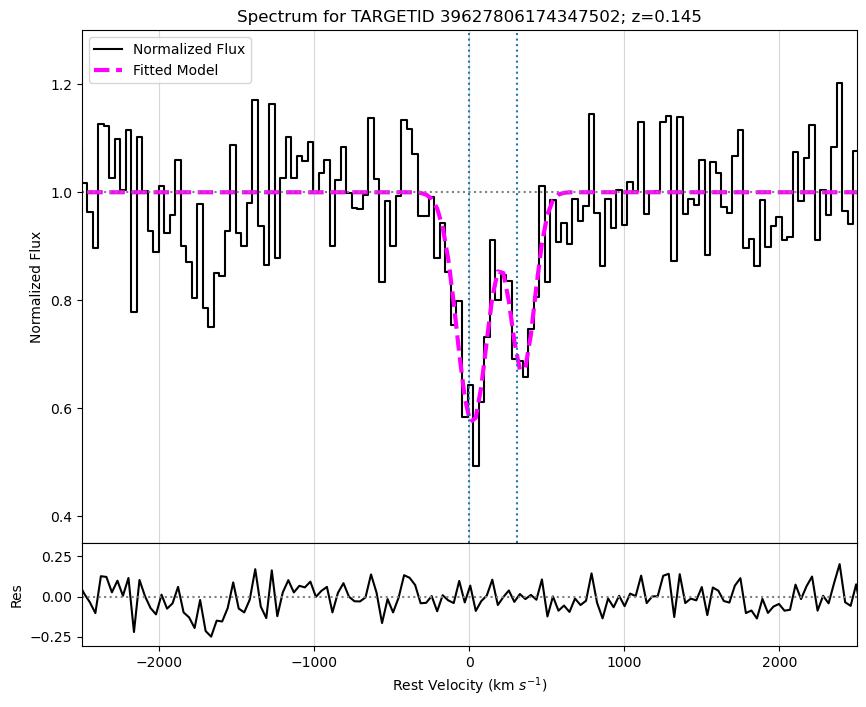

In [220]:
PlotFit_spectrum(1, show=True)

In [221]:
all_samples = np.loadtxt('all_samples.txt')
possible_NaD_samples = np.loadtxt('possible_NaD_samples.txt')
possible_inflow_samples = np.loadtxt('possible_inflow_samples.txt')
possible_outflow_samples = np.loadtxt('possible_outflow_samples.txt')

In [222]:
print(all_samples.shape)
print(possible_NaD_samples.shape)
print(possible_inflow_samples.shape)
print(possible_outflow_samples.shape)

(100638, 5)
(1135, 5)
(323, 5)
(29, 5)


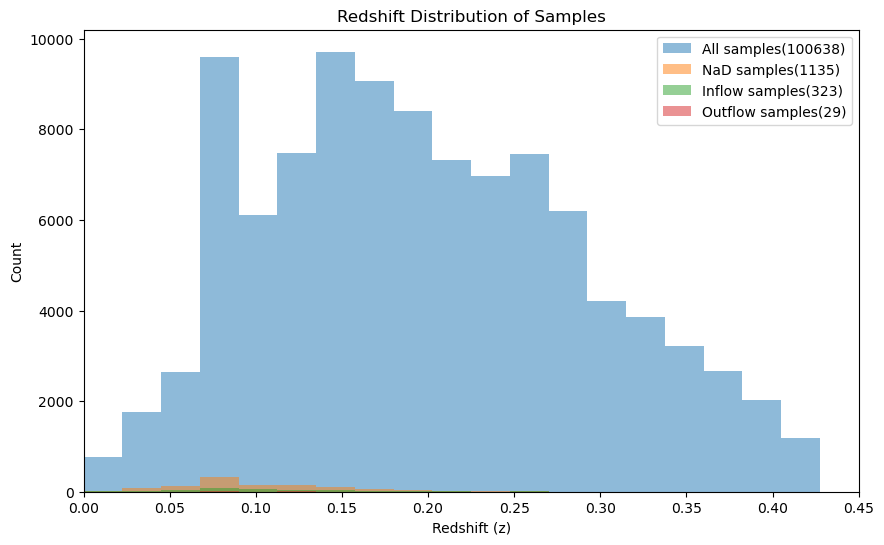

In [223]:
plt.figure(figsize=(10, 6))

# All samples
plt.hist(all_samples[:, 2], bins=20, alpha=0.5, label=f'All samples({len(all_samples)})', range=(0, 0.45), color='C0')

# NaD samples
plt.hist(possible_NaD_samples[:, 2], bins=20, alpha=0.5, label=f'NaD samples({len(possible_NaD_samples)})', range=(0, 0.45), color='C1')

# Inflow samples
plt.hist(possible_inflow_samples[:, 2], bins=20, alpha=0.5, label=f'Inflow samples({len(possible_inflow_samples)})', range=(0, 0.45), color='C2')

# Outflow samples
plt.hist(possible_outflow_samples[:, 2], bins=20, alpha=0.5, label=f'Outflow samples({len(possible_outflow_samples)})', range=(0, 0.45), color='C3')

plt.xlim(left=0, right=0.45)
# plt.yscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel('Count')
plt.legend()
plt.title('Redshift Distribution of Samples')
plt.savefig('./figures/hist/redshift_distribution.pdf', transparent=True)
plt.savefig('./figures/hist/redshift_distribution.png')
plt.show()

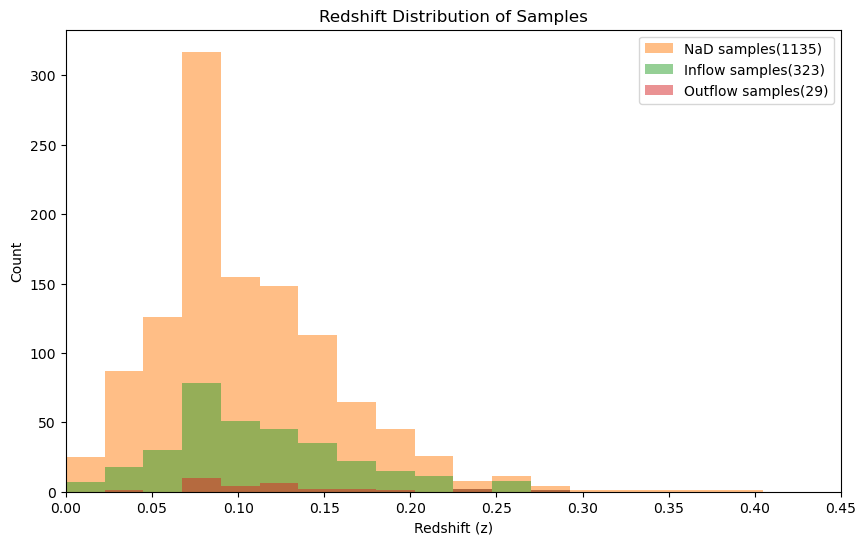

In [224]:
plt.figure(figsize=(10, 6))

# All samples
# plt.hist(all_samples[:, 2], bins=20, alpha=0.5, label=f'All samples({len(all_samples)})', range=(0, 0.45))

# NaD samples
plt.hist(possible_NaD_samples[:, 2], bins=20, alpha=0.5, label=f'NaD samples({len(possible_NaD_samples)})', range=(0, 0.45), color='C1')

# Inflow samples
plt.hist(possible_inflow_samples[:, 2], bins=20, alpha=0.5, label=f'Inflow samples({len(possible_inflow_samples)})', range=(0, 0.45), color='C2')

# Outflow samples
plt.hist(possible_outflow_samples[:, 2], bins=20, alpha=0.5, label=f'Outflow samples({len(possible_outflow_samples)})', range=(0, 0.45), color='C3')

plt.xlim(left=0, right=0.45)
# plt.yscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel('Count')
plt.legend()
plt.title('Redshift Distribution of Samples')
plt.savefig('./figures/hist/redshift_distribution_without_all.pdf', transparent=True)
plt.savefig('./figures/hist/redshift_distribution_without_all.png')
plt.show()

In [225]:
sorted_indices = np.argsort(possible_outflow_samples[:, 3])
possible_outflow_samples = possible_outflow_samples[sorted_indices]

sorted_indices = np.argsort(possible_inflow_samples[:, 3])
possible_inflow_samples = possible_inflow_samples[sorted_indices][::-1, :]

In [226]:
print(possible_outflow_samples[:10,0])
print(possible_inflow_samples[:10,0])

[ 2645. 20336. 24160. 30018. 58038.  9894. 50444. 64489. 74403. 96143.]
[42093. 50511. 28038. 41376. 67730.  4313. 69734. 59563. 12054.  1777.]


In [235]:
print('Outflow samples:')
for i in possible_outflow_samples[:10, 0]:
    z, targetID, RA, DEC, coadd_data, ivar, mask, resting_lam = extract_spectrum(int(i))
    print(f'{RA} {DEC}')

print('\n')
print('Inflow samples:')
for i in possible_inflow_samples[:10, 0]:
    z, targetID, RA, DEC, coadd_data, ivar, mask, resting_lam = extract_spectrum(int(i))
    print(f'{RA} {DEC}')

Outflow samples:
206.84017974472948 0.4706111681326784
221.91648352528267 -1.7494116735367382
183.59339032919738 -1.1386559797895792
222.57995305734755 -1.113182289001043
197.28860970790163 -0.6133465614672265
186.74257109209074 0.42069755003050274
206.47049931222477 -1.744640578377889
209.24637686212688 -0.3425408802958308
190.44875507625648 0.466001358560898
197.07711701179713 -1.2690094042731768


Inflow samples:
213.79229662643476 -1.5916220479409926
207.02244474456182 -1.7660012866179733
224.98307171711127 -1.3295208220674917
206.4414475106856 -0.07026122459589294
189.59890503395738 -0.9667525798880322
218.6128624389646 1.0802947385528552
195.73953814036358 0.719665364033736
196.70911804036896 -0.17284055899925024
200.81114202654453 1.4132183322641232
182.7726907064296 -0.510953651812965


In [236]:
print('Outflow samples:')
for i in possible_outflow_samples[:10, 0]:
    z, targetID, RA, DEC, coadd_data, ivar, mask, resting_lam = extract_spectrum(int(i))
    print(f'{int(i)} {targetID}')
    
print('\n')
print('Inflow samples:')
for i in possible_inflow_samples[:10, 0]:
    z, targetID, RA, DEC, coadd_data, ivar, mask, resting_lam = extract_spectrum(int(i))
    print(f'{int(i)} {targetID}')

Outflow samples:
2645 39627800277157939
20336 39627746170638653
24160 39627757608502998
30018 39627764302612355
58038 39627775958582009
9894 39627799937422527
50444 39627745910592213
64489 39627782195517170
74403 39627800000337419
96143 39627757834995349


Inflow samples:
42093 39627752076215246
50511 39627745923170787
28038 39627758300567363
41376 39627788189175974
67730 39627763748964089
4313 39627812553885871
69734 39627806128216016
59563 39627781985801279
12054 39627824335684933
1777 39627775715312061


In [237]:
for i in possible_outflow_samples[:10, 0]:
    PlotFit_spectrum(int(i), show=False)

for i in possible_inflow_samples[:10, 0]:
    PlotFit_spectrum(int(i), show=False)